---

In [1]:
from pathlib import Path

path = Path().absolute()

In [2]:
cd ../

c:\Users\c10nGp4\OneDrive\Documents\GitHub\imbalance-multi-classification


In [3]:
import pickle
import time

---

### Load Dataset
---

In [4]:
import pandas as pd

df = pd.read_csv(path / "assets/datasets/dataset-1.csv", delimiter=";")

### Instantiate Classifier
---

In [5]:
from pipeline.classification import Classification

clf = Classification()

2023-05-24 01:24:55 INFO: DOWNLOAD STANZA MODEL


2023-05-24 01:24:55 INFO: Downloading default packages for language: id (Indonesian) ...
2023-05-24 01:24:56 INFO: File exists: C:\Users\c10nGp4\stanza_resources\id\default.zip
2023-05-24 01:24:57 INFO: Finished downloading models and saved to C:\Users\c10nGp4\stanza_resources.
2023-05-24 01:24:57 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-24 01:24:57 INFO: LOAD STANZA PIPELINE: tokenize,mwt,pos,lemma


2023-05-24 01:24:58 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2023-05-24 01:24:58 INFO: Using device: cuda
2023-05-24 01:24:58 INFO: Loading: tokenize
2023-05-24 01:25:00 INFO: Loading: mwt
2023-05-24 01:25:01 INFO: Loading: pos
2023-05-24 01:25:01 INFO: Loading: lemma
2023-05-24 01:25:01 INFO: Done loading processors!


### Load Data
---

In [6]:
import pandas as pd

# Load dataset
df = pd.read_csv(path / "assets/datasets/dataset-1.csv", delimiter=";")

# Select specific categories
# df[df["targets"].isin(["kaget","takut"])]

# Get X and y from dataset
X = list(df["texts"])
y = list(df["targets"])

# Reduce data
# _1, X, _2, y = clf.train_test_split(X, y, test_size=.05)

### Data Preparation
---

In [7]:
from pipeline.pos_filter import POS

# Text Preprocessing
X = clf.text_preprocessing_pipeline.transform(X)

# Feature Selection

# emotion classification
clf.feature_selection_pipeline.named_steps["pos_filter"].set_params(**{"pos": POS - set(["DET","INTJ","NUM","PRON","PROPN","PUNCT","SYM","X"])})

# aspect classification
# clf.feature_selection_pipeline.named_steps["pos_filter"].set_params(**{"pos": set(["NOUN","PROPN"])})

# word features
clf.feature_selection_pipeline.named_steps["document_transformer"].set_params(**{"feat_attrs": ["lemma","upos"]})

X = clf.feature_selection_pipeline.transform(X)

# Split
X_train, X_test, y_train, y_test = clf.train_test_split(X, y)

2023-05-24 01:25:01 INFO: TEXT CLEANING
2023-05-24 01:25:03 INFO: TOKENIZE, MWT, POS, LEMMA
2023-05-24 01:26:20 INFO: POS REMOVAL
2023-05-24 01:26:20 INFO: STOPWORD REMOVAL
2023-05-24 01:26:21 INFO: DOCUMENT TRANSFORMER


### Hyper-parameters tuning
---

In [8]:
# from datetime import timedelta

# n_jobs = 1

# param_grid = [
#     {
#         "tfidfvectorizer__ngram_range": ((1,2),),
#         "tfidfvectorizer__min_df": (1,),
#         "tfidfvectorizer__max_df": (1.0,),
#         "svc__kernel": ("linear",),
#         "svc__C": (0.01, 0.1, 1, 10, 100, 1000, 10000)
#     }
# ]

# # param_grid = [
# #     {
# #         "tfidfvectorizer__ngram_range": ((1,2)),
# #         "tfidfvectorizer__min_df": (1,),
# #         "tfidfvectorizer__max_df": (1.0,),
# #         "svc__kernel": ("rbf",),
# #         "svc__C": (0.01, 0.1, 1, 10, 100, 1000, 10000),
# #         "svc__gamma": (0.0001, 0.001, 0.01, 0.1, 1)
# #     }
# # ]

# # param_grid = [
# #     {
# #         "tfidfvectorizer__ngram_range": ((1,2),),
# #         "tfidfvectorizer__min_df": (1,),
# #         "tfidfvectorizer__max_df": (1.0,),
# #         "svc__kernel": ("linear",),
# #         "svc__C": (0.01, 0.1, 1, 10, 100, 1000, 10000),
# #     },
# #     {
# #         "tfidfvectorizer__ngram_range": ((1,2),),
# #         "tfidfvectorizer__min_df": (1,),
# #         "tfidfvectorizer__max_df": (1.0,),
# #         "svc__kernel": ("rbf",),
# #         "svc__C": (0.01, 0.1, 1, 10, 100, 1000, 10000),
# #         "svc__gamma": ("scale",)
# #     }
# # ]

# grid_search, estimation = clf.tuning(X_train, y_train, param_grid, n_jobs, verbose=1)

# print(f"Finished in {str(timedelta(seconds=estimation))}")

# print(f"Best score: {grid_search.best_score_}")

# print("Best hyper-parameters:")
# print(grid_search.best_params_)

In [9]:
# import plotly.express as px

# cv_results = grid_search.cv_results_
            
# cv_results_df = pd.DataFrame(cv_results)
# parallel_coordinates_df = cv_results_df.loc[:, [col_name for col_name in cv_results_df.columns if "param_" in col_name or col_name == "mean_test_score"]]
# parallel_coordinates_df = parallel_coordinates_df.rename(lambda col_name: "MCC" if col_name == "mean_test_score" else col_name.split("__")[-1], axis="columns")

# dimensions = []

# for col_name in parallel_coordinates_df:
#     series = parallel_coordinates_df[col_name]

#     if col_name == "MCC":
#         dimensions.append({
#             "label": col_name,
#             "values": parallel_coordinates_df[col_name],
#             "range": [-1, 1]
#         })

#     else:
#         unique_values = list(series.unique())

#         dimensions.append({
#             "label": col_name,
#             "values": [unique_values.index(value) for value in series],
#             "ticktext": [str(value) for value in unique_values],
#             "tickvals": list(range(len(unique_values)))
#         })

# fig = px.parallel_coordinates(
#     parallel_coordinates_df,
#     color="MCC",
#     color_continuous_scale=px.colors.diverging.RdYlGn,
#     color_continuous_midpoint=0,
#     range_color=[-1,1]
# )

# fig.update_traces(dimensions=dimensions)

### Apply the best hyper-parameters
---

In [10]:
# clf.classification_pipeline.set_params(**grid_search.best_params_)

### Train model
---

In [11]:
# clf.train_preprocessed(X_train, y_train)

### Save model
---

In [12]:
# clf.to_disk(path / "assets/models/")

### Load model
---

In [14]:
filepath = path / "assets/models/model.2023.05.22.02.11.27.952634.pickle"
clf.from_disk(filepath)

### Test model
---

In [15]:
y_pred = clf.test_preprocessed(X_test)

2023-05-24 01:27:39 INFO: MODEL TESTINIG


### Evaluation
---

In [16]:
accuracy, mcc = clf.score(y_test, y_pred)

print("Accuracy:", accuracy)
print("MCC:", mcc)

Accuracy: 0.7082744987291726
MCC: 0.6237471733150306


### Confusion Matrix
---

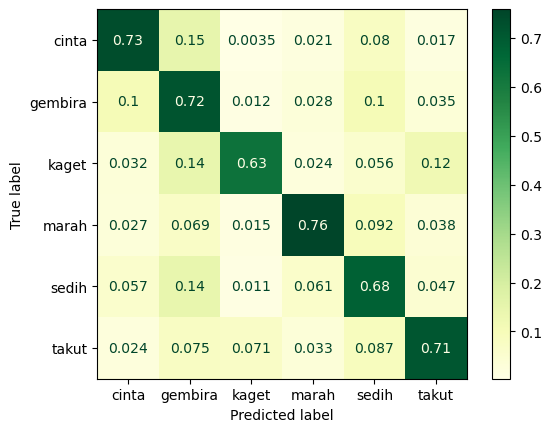

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="YlGn")

## Analysis
---

In [18]:
clf.classification_pipeline.named_steps["tfidfvectorizer"].get_feature_names_out()

array(['aa.NOUN', 'aa.NOUN dengar.VERB', 'aa.NOUN href.NOUN', ...,
       'zumba.NOUN gairah.NOUN', 'zumba.NOUN jam.NOUN',
       'zumba.NOUN renang.VERB'], dtype=object)